In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utm

In [2]:
df = pd.read_csv('../data/AB_NYC_2019.csv')

In [3]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
df.shape

(48895, 16)

In [5]:
# We transform latitude and longitude in UTM coordinates. Because the Earth portion at which we are looking is quite small, UTM provides enough accuracy.
df['utm'] = df.apply(lambda row : utm.from_latlon(row.latitude, row.longitude)[:2], axis=1)
df['utm_x'] = df.apply(lambda row : row.utm[0], axis=1)
df['utm_y'] = df.apply(lambda row : row.utm[1], axis=1)

In [6]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,utm,utm_x,utm_y
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,"(586884.7816290552, 4500133.886065807)",586884.781629,4.500134e+06
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,"(585784.6348931462, 4511903.790469252)",585784.634893,4.511904e+06
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365,"(589244.9423654521, 4518095.410242636)",589244.942365,4.518095e+06
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,"(587901.5063912352, 4504325.790207911)",587901.506391,4.504326e+06
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,"(589082.7126969496, 4516926.585300169)",589082.712697,4.516927e+06


In [7]:
# Only taking a sample of the full dataframe, 50'000 Airbnb lead to too much computations.
seed = 1
n = 5000
df_red = df.sample(n, random_state=seed)

In [8]:
# Standardizing the UTM coordinates
df_coord = df_red[['utm_x', 'utm_y']]
df_coord.utm_x = (df_coord.utm_x - df_coord.utm_x.mean()) / df_coord.utm_x.std()
df_coord.utm_y = (df_coord.utm_y - df_coord.utm_y.mean()) / df_coord.utm_y.std()

//miniconda3/envs/ntds_2019/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [9]:
df_coord.head()

,utm_x,utm_y
18907,1.552033,0.318589
46663,0.611587,0.545267
19757,-0.499501,-0.594698
9705,-0.013973,-0.087503
3322,-0.739066,-0.034959


In [10]:
# Computing distance between all airbnbs.
from scipy.spatial.distance import squareform, pdist
df_dist = pd.DataFrame(squareform(pdist(df_coord.iloc[:, 0:])), columns=df_coord.index, index=df_coord.index)

In [11]:
df_dist.head()

,18907,46663,19757,9705,3322,12637,19383,35358,28001,7201,...,31563,36874,31235,44418,31193,21368,7460,42535,20164,30115
18907,0.000000,0.967378,2.245636,1.617802,2.318217,2.000155,1.916462,0.416932,2.197895,1.445382,...,1.534015,1.768773,3.641113,1.087067,1.642654,0.475077,2.508805,2.333045,2.018593,5.043287
46663,0.967378,0.000000,1.591866,0.889788,1.470009,1.539570,1.568833,0.572471,1.740706,1.167579,...,1.028068,1.333986,4.475369,1.085788,0.756439,1.394046,1.994359,1.480805,1.081058,4.455214
19757,2.245636,1.591866,0.000000,0.702128,0.608851,0.471911,0.697936,1.870078,0.482089,0.944295,...,0.721539,0.601692,4.843246,1.354400,1.819492,2.454344,0.503605,0.626660,1.026413,2.864758
9705,1.617802,0.889788,0.702128,0.000000,0.726994,0.742290,0.861207,1.217125,0.920684,0.695474,...,0.370126,0.607234,4.623506,0.965480,1.211860,1.901564,1.129442,0.744723,0.686247,3.565820
3322,2.318217,1.470009,0.608851,0.726994,0.000000,1.024442,1.239005,1.906349,1.084363,1.316152,...,0.999339,1.057659,5.289166,1.661905,1.435241,2.625470,1.085602,0.020706,0.541453,3.121738


In [12]:
mean = df_dist.mean().mean()
print('The mean distance is {m}'.format(m=mean))

The mean distance is 1.6863646439513824


In [13]:
epsilon = 0.7
sigma = mean * 0.1
def sparsify(x):
    sigm_x = np.exp(- x**2 / (2*sigma**2))
    if sigm_x < epsilon:
        return 0
    return sigm_x

In [14]:
# compute weights of the edges, sparsifying.
df_dist_s = df_dist.applymap(sparsify)
print('there are {i} non-zero entries'.format(i = df_dist_s.astype(bool).sum().sum()))

there are 324866 non-zero entries


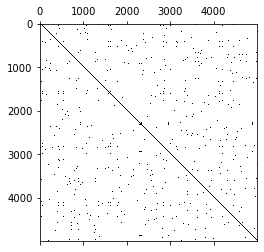

In [15]:
plt.spy(df_dist_s)
plt.show()

In [16]:
# create adjacency matrix, as a numpy array
adj = df_dist_s.values - np.eye(df_dist_s.shape[0])

In [17]:
adj

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
# dictionnary to rename the labels of the nodes according to their indice in the df
nodes_labels = dict(zip(np.arange(n), df_dist_s.index))

In [19]:
# create networkx graph, renaming nodes
import networkx as nx
G = nx.from_numpy_matrix(adj)
G = nx.relabel_nodes(G, nodes_labels)

In [20]:
G.size()

159933

In [21]:
# create dictionnary for nodes positions
coord_dict = df_red.utm.to_dict()

//miniconda3/envs/ntds_2019/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


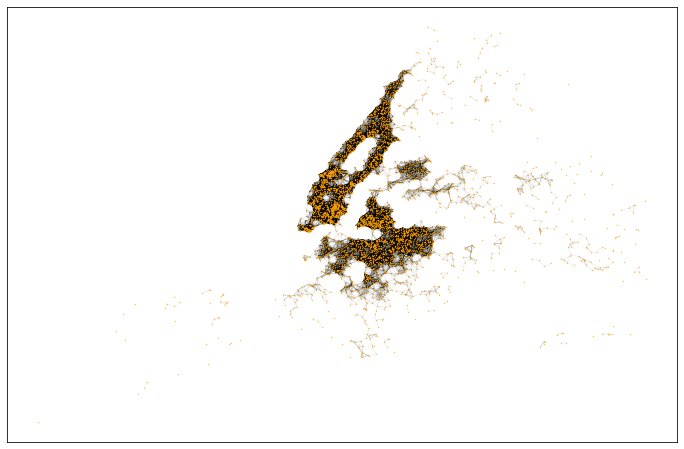

In [22]:
# graph of the airbnb
plt.figure(figsize=(12,8))
nx.draw_networkx(G, pos=coord_dict, with_labels=False, node_size=0.1, node_color='orange', width=0.05)
plt.show()

In [23]:
# different neighbourhood
df_red.neighbourhood_group.value_counts()

Manhattan        2175
Brooklyn         2061
Queens            611
Bronx             117
Staten Island      36
Name: neighbourhood_group, dtype: int64

In [24]:
neighbourhoud_to_int = {
    'Manhattan': 1,
    'Brooklyn': 2,
    'Queens': 3,
    'Bronx': 4,
    'Staten Island': 5
}

In [25]:
ground_truth_nei = df_red.neighbourhood_group.apply(lambda x: neighbourhoud_to_int.get(x)).values
ground_truth_nei[:5]

array([3, 3, 2, 2, 1])

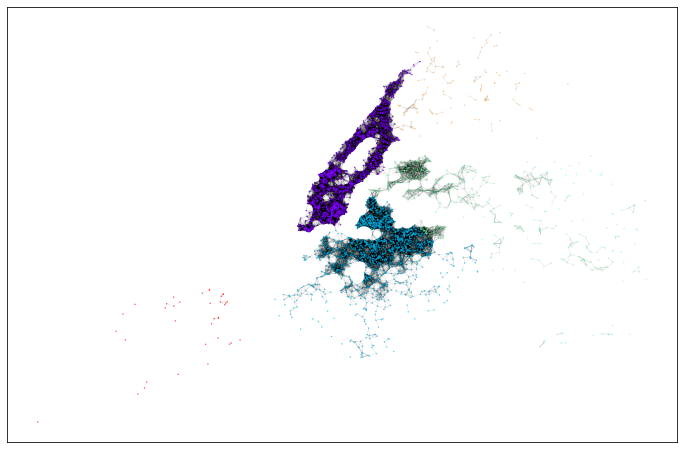

In [26]:
# graph of the airbnb with groundtruth
plt.figure(figsize=(12,8))
nx.draw_networkx(G, pos=coord_dict, with_labels=False, node_size=0.1, cmap=plt.get_cmap('rainbow'), node_color=ground_truth_nei, width=0.05)
plt.show()

We keep only the biggest connected component

In [27]:
Gc = max(nx.connected_component_subgraphs(G), key=len)

In [28]:
Gc_nodes = max(nx.connected_components(G), key=len)

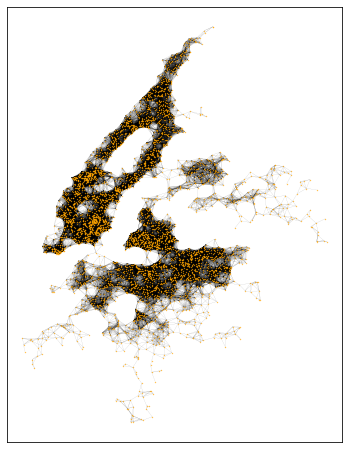

In [29]:
plt.figure(figsize=(6,8))
nx.draw_networkx(Gc, pos=coord_dict, with_labels=False, node_size=0.1, node_color='orange', width=0.05)
plt.show()

Running spectral clustering on the biggest connected component

In [30]:
adj_c = nx.adjacency_matrix(Gc)

In [31]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=3, eigen_solver='amg', affinity='precomputed', n_init=100)
sc.fit(adj_c)

SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
                   degree=3, eigen_solver='amg', eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=3, n_init=100, n_jobs=None,
                   n_neighbors=10, random_state=None)

//miniconda3/envs/ntds_2019/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


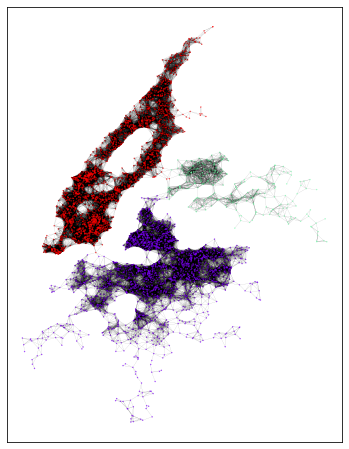

In [32]:
# displaying result of spectrcal clustering
plt.figure(figsize=(6,8))
nx.draw_networkx(Gc, pos=coord_dict, with_labels=False, node_size=0.1, cmap=plt.get_cmap('rainbow'), node_color=sc.labels_, width=0.05)
plt.show()

We can aslo try to run k-means, but it doesn't work well.

In [33]:
from sklearn.cluster import KMeans
km =  KMeans(n_clusters=5, init='k-means++', n_init=1, verbose=1)
km.fit(adj_c)

Initialization complete
Iteration  0, inertia 244443.573
Iteration  1, inertia 196459.672
Iteration  2, inertia 195874.946
Iteration  3, inertia 195482.121
Iteration  4, inertia 194995.946
Iteration  5, inertia 194652.416
Iteration  6, inertia 194478.062
Iteration  7, inertia 194407.447
Iteration  8, inertia 194385.477
Iteration  9, inertia 194373.203
Iteration 10, inertia 194362.965
Iteration 11, inertia 194357.022
Iteration 12, inertia 194353.430
Iteration 13, inertia 194350.094
Iteration 14, inertia 194341.479
Iteration 15, inertia 194339.277
Iteration 16, inertia 194338.403
Converged at iteration 16: center shift 0.000000e+00 within tolerance 1.079921e-06


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=1)

//miniconda3/envs/ntds_2019/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


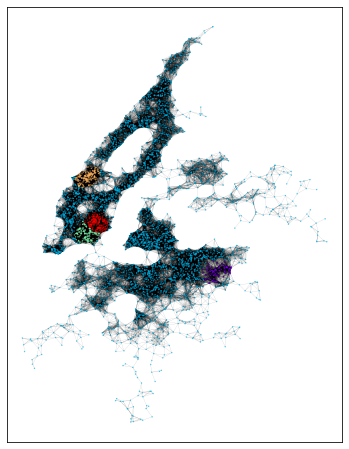

In [34]:
plt.figure(figsize=(6,8)) 
nx.draw_networkx(Gc, pos=coord_dict, with_labels=False, node_size=0.1, cmap=plt.get_cmap('rainbow'), node_color=km.labels_, width=0.05)
plt.show()